In [1]:
input_dim = 228
from PIL import Image, ImageDraw
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import xmltodict

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [3]:
import tqdm
import math
import cv2
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import random
from scipy import misc
import time
import copy
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
images = []
image_paths = glob.glob('D:/44754/Documents/Data/image-localization-dataset/training_images/*.jpg')
for imagefile in image_paths:
    image = Image.open(imagefile).resize((input_dim,input_dim))
    image = np.asarray(image)/255.0
    images.append(image)

In [5]:
bboxes = []
classes_raw = []
annotations_paths = glob.glob( 'D:/44754/Documents/Data/image-localization-dataset/training_images/*.xml' )
for xmlfile in annotations_paths:
    x = xmltodict.parse( open( xmlfile , 'rb' ) )
    bndbox = x[ 'annotation' ][ 'object' ][ 'bndbox' ]
    bndbox = np.array([ int(bndbox[ 'xmin' ]) , int(bndbox[ 'ymin' ]) , int(bndbox[ 'xmax' ]) , int(bndbox[ 'ymax' ]) ])
    bndbox2 = [ None ] * 4
    bndbox2[0] = bndbox[0]
    bndbox2[1] = bndbox[1]
    bndbox2[2] = bndbox[2]
    bndbox2[3] = bndbox[3]
    bndbox2 = np.array( bndbox2 ) / input_dim
    bboxes.append( bndbox2 )
    classes_raw.append( x[ 'annotation' ][ 'object' ][ 'name' ] )

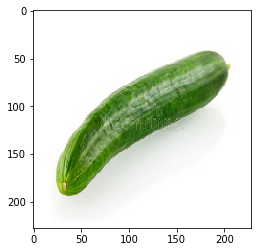

In [6]:
plt.imshow(images[0])

In [7]:
print(len(images),len(bboxes),len(classes_raw))

186 186 186


In [8]:
print(bboxes[0])
print(classes_raw[0])

[0.10087719 0.18421053 0.90350877 0.87280702]
cucumber


In [9]:
print(np.unique(classes_raw))

['cucumber' 'eggplant' 'mushroom']


In [10]:
num_classes = 3
pred_vector_length = 4 + num_classes
alpha = .2

The outputs in this case are the properties of the bounding box and the class probability.

#### Data

In [11]:
boxes = np.array( bboxes ) 
encoder = LabelBinarizer()
classes_onehot = encoder.fit_transform( classes_raw )
Y = np.concatenate( [ boxes , classes_onehot ] , axis=1 )
X = np.array( images )
print(X.shape,Y.shape)

(186, 228, 228, 3) (186, 7)


In [12]:
class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

rotation_transform = MyRotationTransform(angles=[-90, 0, 90, 180])
transformations = transforms.Compose([
        transforms.Resize((228,228)), 
#         rotation_transform,
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [13]:
class CustomDatasetFrom(Dataset): # input np arrays
    def __init__(self,imgs,labels,targets,transform=None):
        self.imgs = imgs # input images
        self.labels = labels # labels
        self.targets = targets # bounding box properties
        self.transforms = transform
    def __getitem__(self,index):
        # Convert image from numpy array to PIL image
        img_as_img = Image.fromarray((self.imgs[index]* 255).astype(np.uint8))
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)
        y=torch.tensor(self.targets[index],dtype=torch.float64)   
        return img_as_tensor, y
    def __len__(self):
        return self.imgs.shape[0]

In [14]:
custom_data = CustomDatasetFrom(X,classes_raw,Y,transformations)
dataloaders = torch.utils.data.DataLoader(custom_data, batch_size=5,
                                    shuffle=True, num_workers=0)

In [15]:
validation_split,test_split = .05,.05
# Creating data indices for training and validation splits:
dataset_size = len(custom_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
test_indices, val_indices = indices[:split], indices[split:split*2]
train_indices = indices[split*2:]
print(len(train_indices),len(test_indices),len(val_indices))

168 9 9


In [16]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(custom_data, batch_size=5, 
                                          sampler=train_sampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(custom_data, batch_size=5,
                                          sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(custom_data, batch_size=1,
                                          sampler=test_sampler, num_workers=0)

#### Model

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
            # Conv: (228,228,3) > (224,224,16) > (112,112,16) 
            # (110,110,32) > (108,108,32) > (54,54,32)
            # (52,52,64) > (50,50,64) > (25,25,64)
            # (23.23.128) > (21,21,128) > (10,10,128)
            # (8,8,256) > (6,6,256) > (3,3,256)
            # FC: (2304) > (1240) > (640) > (480) > (120) > (62) > (7)
        self.convSeq = [3,16,32,64,128,256]
        self.Conv2ds1 = nn.ModuleList([nn.Conv2d(self.convSeq[i-1],
                self.convSeq[i],3,1) for i in range(1,len(self.convSeq))])
        self.Conv2ds2 = nn.ModuleList([nn.Conv2d(self.convSeq[i],
                self.convSeq[i],3,1) for i in range(1,len(self.convSeq))])
        
        self.denSeq = [3*3*256,1240,640,480,120,62,pred_vector_length]
        self.Linears = nn.ModuleList([nn.Linear(self.denSeq[i-1],
                        self.denSeq[i]) for i in range(1,len(self.denSeq))])
    def forward(self, x):
        for i,_ in enumerate(self.Conv2ds1):
            x = F.leaky_relu(self.Conv2ds1[i](x),negative_slope=alpha)
            x = F.leaky_relu(self.Conv2ds2[i](x),negative_slope=alpha)
            x = F.max_pool2d(x,2)
        
        x = x.view(-1, 3*3*256)
        for i,l in enumerate(self.Linears):
            x = F.leaky_relu(l(x),negative_slope=alpha)
        
        return x

In [18]:
learning_rate,momentum = 0.01,0.5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net();model = model.to(device)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                       momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#### Custom Loss Function

In [19]:
def calculate_iou( target_boxes , pred_boxes ):
    xA = torch.max( target_boxes[:, 0], pred_boxes[:, 0].double())
    yA = torch.max( target_boxes[:, 1], pred_boxes[:, 1].double())
    xB = torch.min( target_boxes[:, 2], pred_boxes[:, 2].double())
    yB = torch.min( target_boxes[:, 3], pred_boxes[:, 3].double())
    ref = torch.zeros([1],dtype=torch.double,device=device)
    interArea = torch.max(ref,xB-xA)*torch.max(ref,yB-yA)
    boxAArea = (target_boxes[:,2]-target_boxes[:,0])*(target_boxes[:,3]-target_boxes[:,1])
    boxBArea = (pred_boxes[:,2]-pred_boxes[:,0])*(pred_boxes[:,3]-pred_boxes[:,1])
    iou = interArea / ( boxAArea + boxBArea - interArea )
    return iou

def custom_loss( y_true , y_pred ):
    mse = nn.MSELoss()( y_true , y_pred.double()) 
    iou = calculate_iou( y_true , y_pred.double()) 
    return mse + torch.mean( 1 - iou )

def iou_metric( y_true , y_pred ):
    return calculate_iou( y_true , y_pred ) 

#### Train Model

- It is quite strange to have leakyrelu as the last layer. If the last 3 elements are the probability of the classes, the cross entropy loss should be used. 
- BUT softmax causes backprop untracable.
- The first 4 elements are the properties of the bounding box, they are normalized so that MSE loss is OK.

In [20]:
def train_model(model, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataload = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataload = validation_loader

            running_loss = 0.0
            running_metrics = 0
            running_exp = 0
            # Iterate over data.
            for inputs, targets in tqdm.tqdm(dataload):
                inputs = inputs.to(device)
                targets = targets.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs[:,4:] = nn.Softmax(dim=1)(outputs[:,4:].clone())
                    _, preds = torch.max(outputs[:,4:],1)
                    _, tmptar = torch.max(targets[:,4:],1)
                    loss = custom_loss(targets,outputs)
                
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                tmp_metrics = iou_metric(targets,outputs)
                running_metrics += torch.sum(tmp_metrics)
                running_exp += len(tmp_metrics)

            epoch_loss = running_loss / running_exp
            epoch_metrics = running_metrics.double() / running_exp

            print('{} Loss: {:.4f} IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_metrics))


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model

In [21]:
model_ft = train_model(model, optimizer, num_epochs=50)

Epoch 0/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.40it/s]


train Loss: 1.0463 IOU: 0.1665


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.81it/s]


val Loss: 0.6820 IOU: 0.4427
Epoch 1/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


train Loss: 0.5526 IOU: 0.5519


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 33.99it/s]


val Loss: 0.6497 IOU: 0.4748
Epoch 2/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.51it/s]


train Loss: 0.5444 IOU: 0.5605


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.58it/s]


val Loss: 0.6177 IOU: 0.5023
Epoch 3/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


train Loss: 0.5393 IOU: 0.5647


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.46it/s]


val Loss: 0.6622 IOU: 0.4621
Epoch 4/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


train Loss: 0.5392 IOU: 0.5643


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.17it/s]


val Loss: 0.7700 IOU: 0.3687
Epoch 5/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.24it/s]


train Loss: 0.5328 IOU: 0.5704


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.84it/s]


val Loss: 0.6537 IOU: 0.4719
Epoch 6/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.27it/s]


train Loss: 0.5359 IOU: 0.5672


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.81it/s]


val Loss: 0.6374 IOU: 0.4833
Epoch 7/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.20it/s]


train Loss: 0.5334 IOU: 0.5696


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.18it/s]


val Loss: 0.5886 IOU: 0.5307
Epoch 8/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


train Loss: 0.5201 IOU: 0.5825


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.84it/s]


val Loss: 0.5919 IOU: 0.5282
Epoch 9/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.24it/s]


train Loss: 0.5122 IOU: 0.5900


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.32it/s]


val Loss: 0.6180 IOU: 0.5044
Epoch 10/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.06it/s]


train Loss: 0.5286 IOU: 0.5738


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 38.57it/s]


val Loss: 0.6118 IOU: 0.5086
Epoch 11/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


train Loss: 0.5387 IOU: 0.5644


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.81it/s]


val Loss: 0.6398 IOU: 0.4827
Epoch 12/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


train Loss: 0.5186 IOU: 0.5835


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.84it/s]


val Loss: 0.6980 IOU: 0.4323
Epoch 13/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


train Loss: 0.5264 IOU: 0.5759


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.84it/s]


val Loss: 0.6288 IOU: 0.4944
Epoch 14/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


train Loss: 0.5071 IOU: 0.5948


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.44it/s]


val Loss: 0.6024 IOU: 0.5175
Epoch 15/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


train Loss: 0.5148 IOU: 0.5871


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.18it/s]


val Loss: 0.6009 IOU: 0.5194
Epoch 16/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.33it/s]


train Loss: 0.5233 IOU: 0.5788


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.84it/s]


val Loss: 0.6137 IOU: 0.5088
Epoch 17/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


train Loss: 0.5095 IOU: 0.5923


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.81it/s]


val Loss: 0.6556 IOU: 0.4704
Epoch 18/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


train Loss: 0.5255 IOU: 0.5769


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.46it/s]


val Loss: 0.6717 IOU: 0.4521
Epoch 19/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


train Loss: 0.5266 IOU: 0.5761


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.18it/s]


val Loss: 0.6248 IOU: 0.4983
Epoch 20/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.20it/s]


train Loss: 0.5103 IOU: 0.5913


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.11it/s]


val Loss: 0.6464 IOU: 0.4793
Epoch 21/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.59it/s]


train Loss: 0.5082 IOU: 0.5935


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.81it/s]


val Loss: 0.6221 IOU: 0.5007
Epoch 22/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


train Loss: 0.5050 IOU: 0.5967


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.14it/s]


val Loss: 0.6168 IOU: 0.5057
Epoch 23/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


train Loss: 0.5134 IOU: 0.5885


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.12it/s]


val Loss: 0.6175 IOU: 0.5051
Epoch 24/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


train Loss: 0.5150 IOU: 0.5872


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.84it/s]


val Loss: 0.6481 IOU: 0.4775
Epoch 25/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


train Loss: 0.5314 IOU: 0.5716


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.46it/s]


val Loss: 0.6035 IOU: 0.5176
Epoch 26/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


train Loss: 0.5270 IOU: 0.5757


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.58it/s]


val Loss: 0.6276 IOU: 0.4953
Epoch 27/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


train Loss: 0.5203 IOU: 0.5820


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.81it/s]


val Loss: 0.6279 IOU: 0.4948
Epoch 28/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.29it/s]


train Loss: 0.5141 IOU: 0.5878


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.46it/s]


val Loss: 0.6158 IOU: 0.5071
Epoch 29/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


train Loss: 0.5113 IOU: 0.5904


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.84it/s]


val Loss: 0.6238 IOU: 0.4969
Epoch 30/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


train Loss: 0.5178 IOU: 0.5842


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.14it/s]


val Loss: 0.6173 IOU: 0.5048
Epoch 31/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.94it/s]


train Loss: 0.5210 IOU: 0.5811


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.58it/s]


val Loss: 0.6280 IOU: 0.4956
Epoch 32/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


train Loss: 0.5167 IOU: 0.5855


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.14it/s]


val Loss: 0.6228 IOU: 0.5000
Epoch 33/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.29it/s]


train Loss: 0.5157 IOU: 0.5863


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.81it/s]


val Loss: 0.6296 IOU: 0.4930
Epoch 34/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


train Loss: 0.5164 IOU: 0.5856


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.57it/s]


val Loss: 0.5859 IOU: 0.5345
Epoch 35/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


train Loss: 0.5180 IOU: 0.5843


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.11it/s]


val Loss: 0.6217 IOU: 0.5013
Epoch 36/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


train Loss: 0.5122 IOU: 0.5896


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.49it/s]


val Loss: 0.6354 IOU: 0.4888
Epoch 37/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.41it/s]


train Loss: 0.5098 IOU: 0.5922


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.94it/s]


val Loss: 0.5923 IOU: 0.5280
Epoch 38/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.69it/s]


train Loss: 0.5156 IOU: 0.5863


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 30.85it/s]


val Loss: 0.6483 IOU: 0.4779
Epoch 39/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.49it/s]


train Loss: 0.5058 IOU: 0.5956


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.93it/s]


val Loss: 0.6250 IOU: 0.4990
Epoch 40/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.71it/s]


train Loss: 0.5034 IOU: 0.5983


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.74it/s]


val Loss: 0.6074 IOU: 0.5145
Epoch 41/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.59it/s]


train Loss: 0.5036 IOU: 0.5982


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 30.85it/s]


val Loss: 0.6051 IOU: 0.5167
Epoch 42/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.67it/s]


train Loss: 0.5308 IOU: 0.5719


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.93it/s]


val Loss: 0.6900 IOU: 0.4406
Epoch 43/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.47it/s]


train Loss: 0.5054 IOU: 0.5959


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 30.38it/s]


val Loss: 0.6281 IOU: 0.4963
Epoch 44/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.67it/s]


train Loss: 0.5133 IOU: 0.5887


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.49it/s]


val Loss: 0.6063 IOU: 0.5155
Epoch 45/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.67it/s]


train Loss: 0.4994 IOU: 0.6020


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.49it/s]


val Loss: 0.6412 IOU: 0.4833
Epoch 46/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.52it/s]


train Loss: 0.5090 IOU: 0.5926


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.97it/s]


val Loss: 0.6382 IOU: 0.4862
Epoch 47/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.48it/s]


train Loss: 0.5003 IOU: 0.6011


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 28.24it/s]


val Loss: 0.6007 IOU: 0.5198
Epoch 48/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.52it/s]


train Loss: 0.5339 IOU: 0.5689


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.93it/s]


val Loss: 0.6455 IOU: 0.4805
Epoch 49/49
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.79it/s]


train Loss: 0.5089 IOU: 0.5929


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.05it/s]


val Loss: 0.6503 IOU: 0.4742
Training complete in 2m 4s


In [92]:
imgs,labels,tars = [],[],[]
with torch.no_grad():
    for i,(inputs,targets) in enumerate(test_loader):
        tmpimg = np.transpose(inputs.numpy().squeeze(),(1,2,0))
        inputs = inputs.to(device)
        outputs = model(inputs)
        x1,y1,x2,y2 = (targets[:,:4].numpy().squeeze()*228).astype(int)
        tmpimg2 = cv2.rectangle(tmpimg.copy(),(x1,y1),(x2,y2),(255,0,0),2)
        x1_,y1_,x2_,y2_ = (outputs[:,:4].cpu().numpy().squeeze()*228).astype(int)
        tmpimg3 = cv2.rectangle(tmpimg2.copy(),(x1_,y1_),(x2_,y2_),(0,0,255),2)
        imgs.append(tmpimg3)
        
        _,preds = torch.max(outputs[:,4:],1)
        _,tmptar = torch.max(targets[:,4:],1)
        labels.append(preds.item())
        tars.append(tmptar.item())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


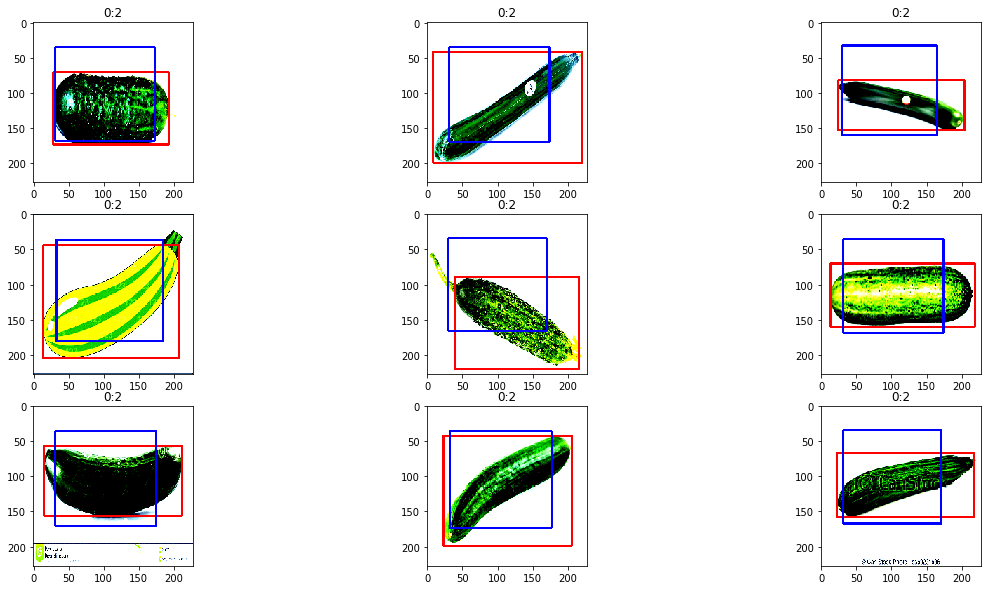

In [93]:
plt.figure(figsize=(20,10))
for i in range(len(imgs)):
    plt.subplot(3,3,i+1); plt.imshow(imgs[i])
    plt.title(str(tars[i])+':'+str(labels[i]))